# Architecture testing with supervised learning

In this notebook I want to test the well-functioning of the various architectures proposed for the actor and the critic.

The setup is the following:
1. Generate a series of states s
2. Use optimal policy to associate them with an optimal action* a 
3. Train only the actor architecture with cross-entropy loss

*one could also use the optimal probabilities if known, but anyway if done in an unbiased way, the sampling procedure will be enough to learn stochastic policies.

Since we already have an optimal policy implemented for sandbox environment and all the code ready for playing episodes, we can build a training set starting from trajectories and then sample simple (s,a) tuples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from Utils import test_env, utils
from Utils.supervised import *

from RelationalModule import AC_networks as nets
from RelationalModule.MLP_AC_networks import Actor

from importlib import reload

In [2]:
reload(test_env)

<module 'Utils.test_env' from '/m/home/home9/94/dainesn1/unix/Workdir/RelationalDeepRL/Utils/test_env.py'>

In [3]:
def supervised_training(net, lr, n_epochs, n_samples, game_params):
    env = test_env.Sandbox(**game_params)
    print("\nCreating dataset...")
    state_set, action_set = create_action_state_set(game_params, size=n_samples)
    train_loader, val_loader, test_loader = prepare_dataset(state_set, action_set, 0.8, 0.2)
    dataloader_dict = dict(train_loader=train_loader,
                           val_loader=val_loader,
                           test_loader=test_loader)
    print("\nTraining network...")
    net, train_loss, val_loss = train_NN(net, lr, n_epochs, train_loader, val_loader, return_model=True)
    
    return net, train_loss, val_loss, dataloader_dict, state_set, action_set, env

# Coordinate state representation

In [4]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=False, return_coord=True)

In [5]:
lr = 5e-4
n_epochs = 20
coord_net = Actor(action_space=4, observation_space=5, hiddens=[64,32,16])

In [6]:
results = supervised_training(coord_net, lr, n_epochs, 100000, game_params)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 100% 	 Train loss: 1.2657 took: 1.83s  Val. loss: 1.0728
Epoch 2, 100% 	 Train loss: 0.9751 took: 1.31s  Val. loss: 0.9277
Epoch 3, 100% 	 Train loss: 0.9146 took: 1.59s  Val. loss: 0.9014
Epoch 4, 100% 	 Train loss: 0.8914 took: 1.50s  Val. loss: 0.8812
Epoch 5, 100% 	 Train loss: 0.8731 took: 1.54s  Val. loss: 0.8660
Epoch 6, 100% 	 Train loss: 0.8567 took: 1.58s  Val. loss: 0.8471
Epoch 7, 100% 	 Train loss: 0.8405 took: 1.10s  Val. loss: 0.8324
Epoch 8, 100% 	 Train loss: 0.8249 took: 1.24s  Val. loss: 0.8168
Epoch 9, 100% 	 Train loss: 0.8110 took: 1.54s  Val. loss: 0.8021
Epoch 10, 100% 	 Train loss: 0.7984 took: 1.58s  Val. loss: 0.7909
Epoch 11, 100% 	 Train loss: 0.7880 took: 1.55s  Val. loss: 0.7792
Epoch 12, 100% 	 Train loss: 0.7793 took: 1.41s  Val. loss: 0.7714
Epoch 13, 100% 	 Train loss: 0.7721 took: 1.65s  Val. loss: 0.7673
Epoch 14, 100% 	 Train loss: 0.7666 took: 1.64s  Val. loss: 0.7

In [7]:
trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [49]:
import string
import random

save = True
keywords = ['coord','10by10','100000-samples','20-epochs','lr5e-4'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    torch.save(trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/SupervisedS_coord_10by10_100000-samples_20-epochs_lr5e-4_EFUT


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be ch

In [8]:
# state set = [x_agent, y_agent, x_goal, y_goal, near_boundary]
X, Y = env.boundary[0], env.boundary[1]
x_agent = (state_set[:,0]*X).astype(int)
y_agent = (state_set[:,1]*Y).astype(int)
x_goal = (state_set[:,2]*X).astype(int)
y_goal = (state_set[:,3]*Y).astype(int)

possible_combinations = (X**2)*(Y**2)
print("Possible number of states: ", possible_combinations)


Possible number of states:  10000


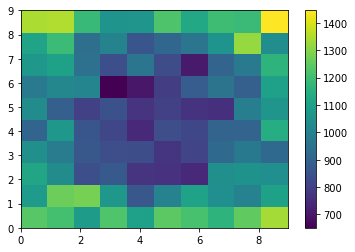

In [9]:
plt.hist2d(x_goal, y_goal, bins = [X,Y])
plt.colorbar()
plt.show()

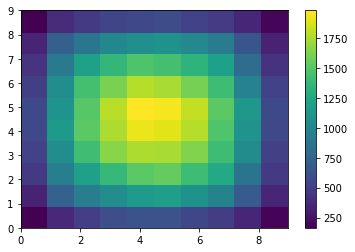

In [10]:
plt.hist2d(x_agent, y_agent, bins = [X,Y])
plt.colorbar()
plt.show()

The dataset is unbalanced in the experience... 

In [11]:
def random_start(X=10, Y=10):
    s1, s2 = np.random.choice(X*Y, 2, replace=False)
    initial = [s1//X, s1%X]
    goal = [s2//X, s2%X]
    return initial, goal

In [12]:
initials = []
goals = []
N = 100000
for i in range(N):
    initial, goal = random_start(10,10)
    initials.append(initial)
    goals.append(goal)

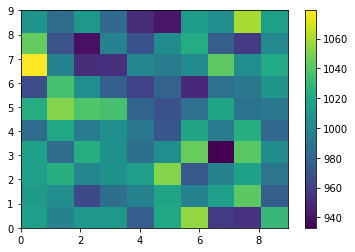

In [13]:
initials = np.array(initials)
x_initials = initials[:,0]
y_initials = initials[:,1]
plt.hist2d(x_initials, y_initials, bins = [10,10])
plt.colorbar()
plt.show()

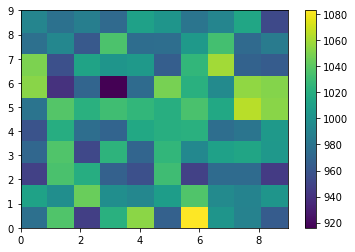

In [14]:
goals = np.array(goals)
x_goals = goals[:,0]
y_goals = goals[:,1]
plt.hist2d(x_goals, y_goals, bins = [10,10])
plt.colorbar()
plt.show()

This is not because of the initial conditions, but probably is due to the fact that all info that we collect comes from real trajectories! So basically we see more the goals in the corners because it takes more time to get there on average, so they are present in more frames. At the same time, we see the agent more in the center probably because it's the place where it passes more times. A work around on this is to avoid playing the whole episode and just taking the initial state and the optimal action in that state.

In [15]:
env = test_env.Sandbox(**game_params)

# choose state and see if the agent classifies it correctly
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# vertical direction is x (first coordinate)
# horizontal direction is y (second coordinate)
state = [3,2]
goal = [4,4]
env.state = state
env.goal = goal
enc_state = env.enc_to_coord()
x = torch.tensor(enc_state).float().to(device)
log_probs = trained_net(x)
probs = torch.exp(log_probs)
for i in range(4):
    print("Action "+env.action_dict[i]+" taken with p = %.2f"%(probs[i]*100))
print(env)

Action Right taken with p = 54.60
Action Left taken with p = 0.30
Action Down taken with p = 44.13
Action Up taken with p = 0.97
Use greyscale state:  False
Use coordinate state:  True
Use one hot encoding state:  False
Boundary:  [10 10]
Initial position:  [4 8]
Current position:  [3, 2]
Goal position:  [4, 4]
Optimal actions: 
	Right
	Down
Greyscale representation: 
 [[[3 3 3 3 3 3 3 3 3 3 3 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 1 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 2 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 0 0 0 0 0 0 0 0 0 0 3]
  [3 3 3 3 3 3 3 3 3 3 3 3]]]



In [45]:
def plot_decision_map(env, net, goal, coord=True):
    env.goal = goal
    
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    probabilities = []
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            if [x,y] != goal:
                env.state = [x,y]
                if coord:
                    enc_state = env.enc_to_coord()
                else:
                    grey_state = env.enc_to_grey()
                    enc_state = env.grey_to_onehot(grey_state)
                enc_state = torch.tensor(enc_state).float().to(device)
                log_probs = net(enc_state).squeeze()
                probs = torch.exp(log_probs).cpu().detach().numpy()
                
            else:
                probs = np.zeros(env.n_actions)
            probabilities.append(probs)
            
    probs = np.array(probabilities).reshape((env.boundary[0],env.boundary[1],-1))
    
    fig = plt.figure(figsize=(8,8))
    fig.suptitle('Goal in [%d,%d]'%(goal[0],goal[1]), fontsize=18, y=1, x=0.48)
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax3 = plt.subplot(2,2,3)
    ax4 = plt.subplot(2,2,4)
    axes = [ax1, ax2, ax3, ax4]
    for i, ax in enumerate(axes):
        im = ax.imshow(probs[:,:,i], cmap='plasma', vmin=0, vmax=1)
        ax.set_title("Prob of moving "+env.action_dict[i], fontsize=16)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.colorbar(im, ax=ax, shrink=0.77)
    plt.tight_layout()
    
    return probs

probs.shape:  (10, 10, 4)
probs:  [[[4.46486473e-01 3.95276656e-05 5.53473175e-01 8.76952811e-07]
  [4.99468505e-01 6.43370586e-05 5.00466704e-01 5.23301992e-07]
  [5.58147728e-01 1.08243898e-04 4.41743791e-01 2.94652835e-07]
  [6.19669378e-01 1.89116763e-04 3.80141497e-01 1.64240504e-07]
  [6.82801545e-01 3.43698019e-04 3.16854626e-01 9.25931047e-08]
  [7.37574756e-01 6.14891062e-04 2.61810362e-01 5.07411890e-08]
  [7.82231510e-01 1.05508941e-03 2.16713294e-01 2.82265376e-08]
  [8.08457255e-01 2.10693828e-03 1.89435616e-01 1.91620835e-08]
  [7.17645049e-01 9.38999187e-03 2.72964835e-01 2.52682977e-08]
  [3.82157117e-01 6.22323826e-02 5.55610359e-01 5.06584108e-08]]

 [[3.98977876e-01 3.00395895e-05 6.00989997e-01 1.98732641e-06]
  [4.77585077e-01 5.23709423e-05 5.22362351e-01 3.87049511e-07]
  [5.35252988e-01 8.55438193e-05 4.64661241e-01 2.14868209e-07]
  [5.90738714e-01 1.38496893e-04 4.09122586e-01 1.21629412e-07]
  [6.39531076e-01 2.23609110e-04 3.60245228e-01 7.08912964e-08]
  [6

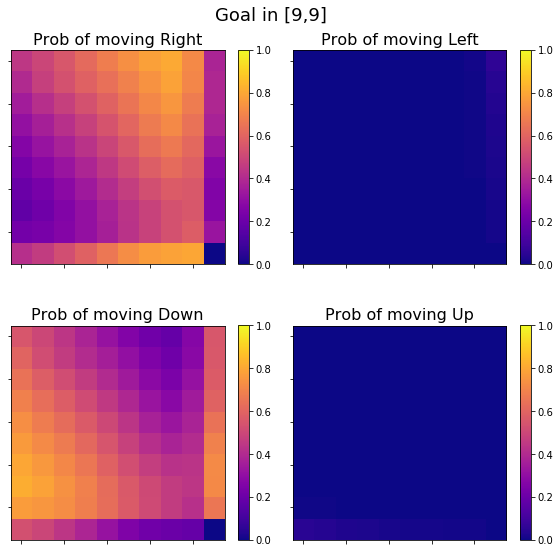

In [41]:
goal = [9,9]
probs = plot_decision_map(env, trained_net, goal)

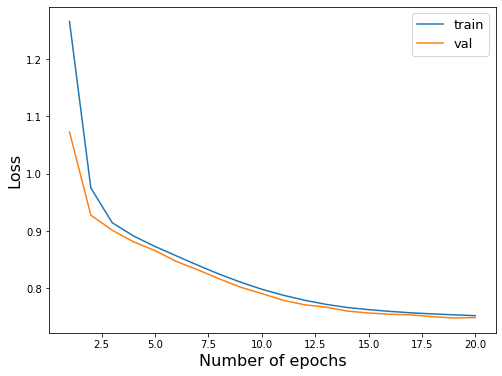

In [18]:
%matplotlib inline
plot_results(train_loss, val_loss)

In [19]:
coord_agent = OheAgent(trained_net, device='cuda')

In [25]:
game_params['initial'] = [0,0]
game_params['goal'] = [9,9]

env = test_env.Sandbox(**game_params)

In [26]:
reload(utils)

<module 'Utils.utils' from '/m/home/home9/94/dainesn1/unix/Workdir/RelationalDeepRL/Utils/utils.py'>

<IPython.core.display.Javascript object>


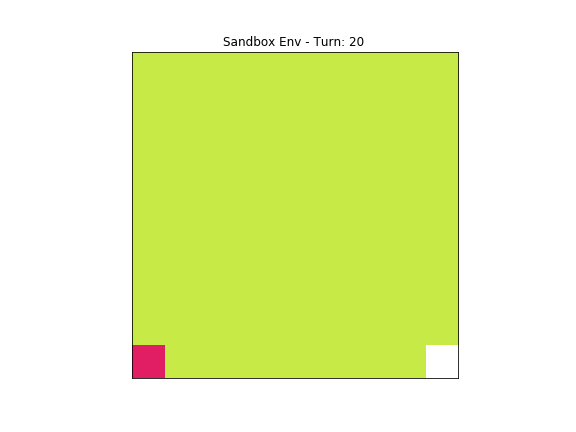

In [28]:
%matplotlib notebook
utils.render(coord_agent, env=env, greedy=True)

%matplotlib inline

## One Hot Encoded state representation

In [2]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [2,2]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [3]:
lr = 5e-4
n_epochs = 5
ohe_net = nets.OheActor(action_space=4, map_size=5) #check mapsize

In [5]:
%%time
results = supervised_training(ohe_net, lr, n_epochs, 10000, game_params)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 100% 	 Train loss: 1.3933 took: 2.51s  Val. loss: 1.3522
Epoch 2, 100% 	 Train loss: 1.2913 took: 0.97s  Val. loss: 1.2423
Epoch 3, 100% 	 Train loss: 1.1707 took: 1.06s  Val. loss: 1.1429
Epoch 4, 100% 	 Train loss: 1.0843 took: 0.98s  Val. loss: 1.0706
Epoch 5, 100% 	 Train loss: 1.0255 took: 1.12s  Val. loss: 1.0270
Training finished, took 6.99s


In [9]:
trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

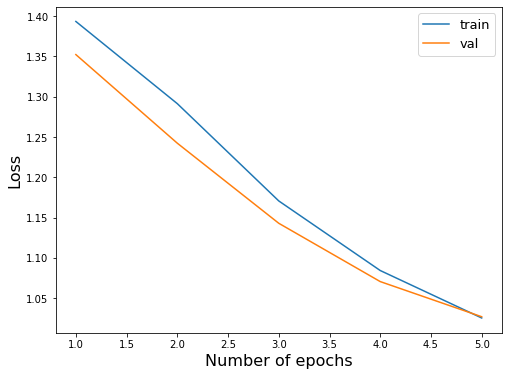

In [10]:
plot_results(train_loss, val_loss)

As a result I don't expect a loss of 0, because in many states there are 2 possible choices to make, e.g. if I have to go right and down, I can equally go down and then left, so each choice can be taken with arbitrary probability, as long as the choice remains between the two actions (said in other words, the probability of choosing one of those 2 actions is 1).

Anyway, the loss function is the average of - log of the probability of coosing the optimal action, so will be 0 if all actions are certain and the network classifies all of them correctly, and will be -log(0.5) = 0.693 if every action is selected with 0.5 probability. So for sure an optimal classifier should score less than 0.693 to be said so (because there are states where a single optimal action is possible).

Actually if we assume all states to be equally probable (that is a bad assumption actually, because we will always find more states where the agent is near the goal if the states are collected from optimal trajectories), we can make a computation to see how much the optimal loss should be.

Calling X the linear size of the map, we have 2X-2 states out of X^2 - 1 in which there is only an optimal action, and X^2 - 1 - 2X + 2 in which there are 2. 

$$ L(X) = -\frac{2X-2}{X^2 - 1}log(1) - \frac{X^2 - 2X + 1}{X^2 - 1}log(0.5) = \frac{X-1}{X+1}\cdot0.69$$

hence L(5) = 0.46.

This training is far from optimal and that probably depends on the fact that is failing to recognize corners and walls...

### From supervised to real actor

To test how the training looks like, we can use the net to see if the result is optimal or not.

In [11]:
ohe_agent = OheAgent(trained_net, device='cuda')

In [12]:
game_params['initial'] = [0,0]
game_params['goal'] = [3,3]

env = test_env.Sandbox(**game_params)

<IPython.core.display.Javascript object>


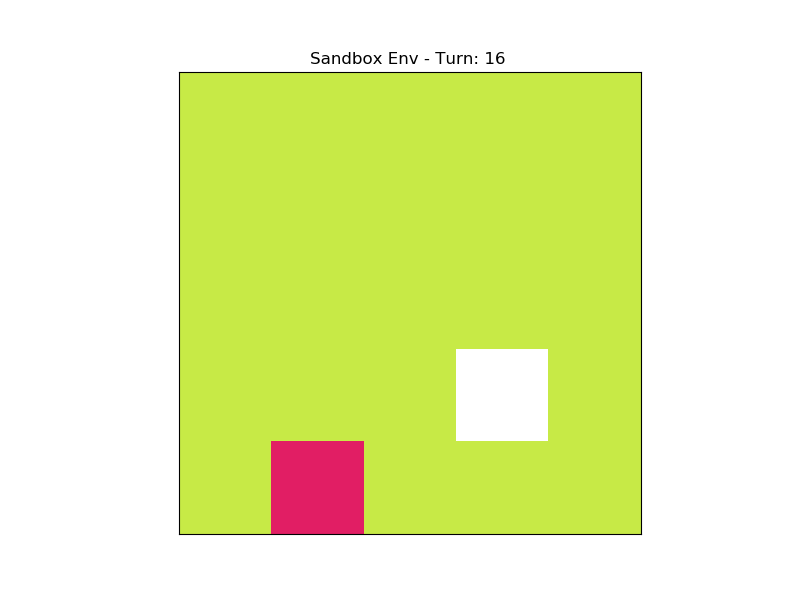

KeyboardInterrupt: 

In [13]:
%matplotlib notebook
utils.render(ohe_agent, env=env, greedy=False)

%matplotlib inline

# Relational agent

In [31]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [2,2]
MAX_STEPS = 20

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [34]:
lr = 5e-4
n_epochs = 50
relational_actor_net = nets.GatedBoxWorldActor(action_space=4)

In [35]:
results = supervised_training(relational_actor_net, lr, n_epochs, 100000, game_params)


Creating dataset...

Training network...
Verbose:  True
Using cuda:  True
Epoch 1, 100% 	 Train loss: 1.3875 took: 17.40s  Val. loss: 1.3859
Epoch 2, 100% 	 Train loss: 1.2515 took: 18.08s  Val. loss: 1.0554
Epoch 3, 100% 	 Train loss: 0.9856 took: 17.95s  Val. loss: 0.9497
Epoch 4, 100% 	 Train loss: 0.8772 took: 20.94s  Val. loss: 0.8125
Epoch 5, 100% 	 Train loss: 0.8153 took: 18.85s  Val. loss: 0.7879
Epoch 6, 100% 	 Train loss: 0.7970 took: 19.57s  Val. loss: 0.7780
Epoch 7, 100% 	 Train loss: 0.7827 took: 17.39s  Val. loss: 0.7626
Epoch 8, 100% 	 Train loss: 0.7781 took: 17.34s  Val. loss: 0.7735
Epoch 9, 100% 	 Train loss: 0.7676 took: 19.48s  Val. loss: 0.7692
Epoch 10, 100% 	 Train loss: 0.7606 took: 18.47s  Val. loss: 0.7515
Epoch 11, 100% 	 Train loss: 0.7586 took: 18.34s  Val. loss: 0.7591
Epoch 12, 100% 	 Train loss: 0.7530 took: 17.98s  Val. loss: 0.7398
Epoch 13, 100% 	 Train loss: 0.7540 took: 18.37s  Val. loss: 0.7462
Epoch 14, 100% 	 Train loss: 0.7485 took: 19.39s  

In [36]:
relational_trained_net, train_loss, val_loss, dataloader_dict, state_set, action_set, env = results

In [50]:
import string
import random

save = True
keywords = ['relational','10by10','100000-samples','50-epochs','lr5e-4'] # example

if save:
    save_dir = 'Results/Sandbox/Supervised'
    ID = ''.join([random.choice(string.ascii_letters) for _ in range(4)])
    ID = ID.upper()
    keywords.append(ID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    torch.save(relational_trained_net, save_dir+"net_"+filename)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/SupervisedS_relational_10by10_100000-samples_50-epochs_lr5e-4_WTHZ


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Convolution. It won't be checked for correctness upon loading.
  "type " + obj.__na

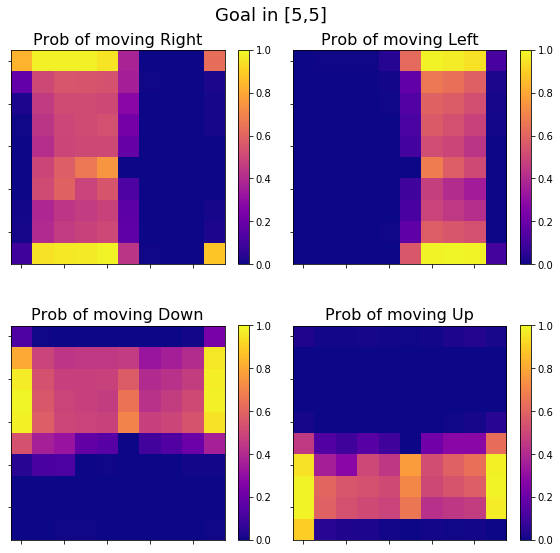

In [47]:
goal = [5,5]
probs = plot_decision_map(env, relational_trained_net, goal, coord=False)